## - Import

In [191]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch
import numpy as np 
import pandas as pd  
import os 
from torchvision.datasets import SVHN 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from tqdm import tqdm


import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image#
import shutil

In [192]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [193]:
torch.cuda.empty_cache()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "gan")
if  os.path.exists(GAN_LOGS):
    shutil.rmtree(GAN_LOGS)
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)

writer = SummaryWriter(GAN_LOGS)

In [ ]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
shutil.rmtree("imgs/training")
if not os.path.exists("imgs/training"):
    os.makedirs("imgs/training")

## - Parameters

In [194]:
transform = transforms.Compose([
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [195]:
train_dataset=SVHN(split='train',root='data/train',transform=transform,download=True)
# test_dataset=SVHN(split='test',root='data/test',transform=transform)

# vars(train_dataset)

Using downloaded and verified file: data/train/train_32x32.mat


In [196]:
class_list = {'0','1','2','3','4','5','6','7','8','9'}

In [197]:
# Data


img_size = 32 # Image size
batch_size = 32  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 12  # Train epochs
learning_rate = 1e-4
class_num=10
channels=3

In [198]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
# val_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [199]:
a,b=next(iter(train_loader))
a.shape

torch.Size([32, 3, 32, 32])

## - Generator

In [200]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size*channels),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        # Generator out
        out = self.model(x)
        
        return out.view(-1,channels, self.img_size, self.img_size)

## - Discriminator

In [201]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size*channels + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, channels*self.img_size * self.img_size)
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        # return out
        return out.squeeze()

In [202]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

## - Adversarial Learning of Generator & Discriminator

In [203]:
# Loss function
criterion = nn.BCELoss()

In [204]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [205]:
criterion_d_real = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
criterion_d_fake = lambda pred: F.binary_cross_entropy(pred, torch.zeros(pred.shape[0], device=pred.device))
criterion_g = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))

In [206]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    # print(validity.shape)
    # Calculating discrimination loss (fake images)
    # g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    # g_loss = criterion(validity, torch.ones(validity.shape[0], device=validity.device))
    g_loss = criterion_g(validity.view(batch_size))
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [207]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()
    B = real_images.shape[0]

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    # real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    # real_loss = criterion(real_validity, torch.ones(real_validity.shape[0], device=real_validity.device))
    real_loss =criterion_d_real(real_validity)
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    # print(fake_validity.shape)
    
    # Calculating discrimination loss (fake images)
    # fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    # fake_loss = criterion(fake_validity, torch.ones(fake_validity.shape[0], device=fake_validity.device))
    fake_loss=criterion_d_fake(fake_validity.view(B))
    # Sum two losses
    d_loss = real_loss , fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

In [208]:
def train_gan(epochs,discriminator,train_loader,generator,g_optimizer=g_optimizer,batch_size=batch_size,d_optimizer=d_optimizer):
    iter_ = 0
    for epoch in range(epochs):
        
        print('Starting epoch {}...'.format(epoch+1))
        
        for i, (images, labels) in enumerate(train_loader):
            
            # Train data
            real_images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            
            # Set generator train
            generator.train()
            
            # Train discriminator
            real_loss , fake_loss = discriminator_train_step(len(real_images), discriminator,
                                            generator, d_optimizer, criterion,
                                            real_images, labels)
            d_loss = real_loss + fake_loss
            
            # Train generator
            g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
            writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
            writer.add_scalar(f'Loss/Discriminator Loss', real_loss.item(), global_step=iter_)
            writer.add_scalars(f'Loss/Discriminator Losses', {
                        "Real Images Loss": real_loss.item(),
                        "Fake Images Loss": fake_loss.item(),
                    }, global_step=iter_)
            writer.add_scalars(f'Comb_Loss/Losses', {
                            'Discriminator': d_loss.item(),
                            'Generator':  g_loss.item()
                        }, iter_) 
            iter_=iter_+1
        
        # Set generator eval
        generator.eval()
        
        print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
        
        # Building z 
        z = Variable(torch.randn(class_num-1, z_size)).to(device)
        
        # Labels 0 ~ 8
        labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
        
        # Generating images
        sample_images = generator(z, labels).data.cpu()
        # print(sample_images.shape)
        # Show images
        grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
        plt.imshow(grid)
        plt.show()

Starting epoch 1...
g_loss: 1.647714614868164, d_loss: 0.8713918328285217


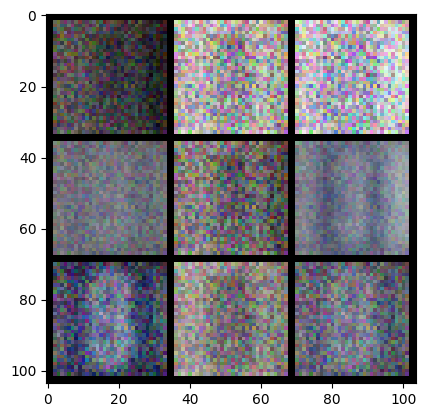

Starting epoch 2...
g_loss: 1.6940090656280518, d_loss: 2.165163278579712


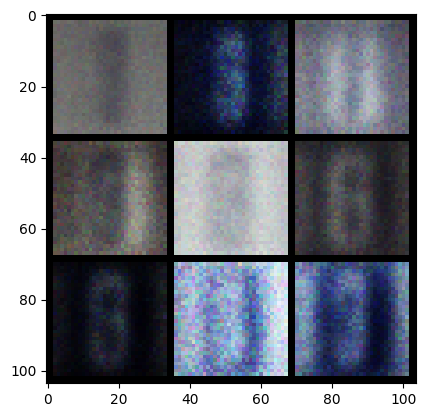

Starting epoch 3...
g_loss: 1.1163287162780762, d_loss: 1.4376190900802612


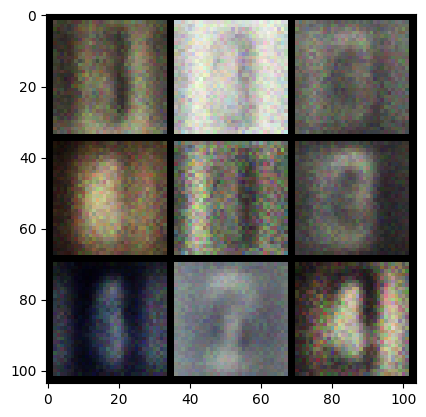

Starting epoch 4...
g_loss: 1.0400217771530151, d_loss: 1.345937728881836


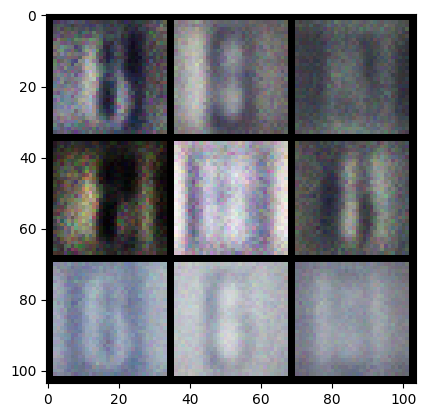

Starting epoch 5...
g_loss: 0.9198854565620422, d_loss: 1.0567705631256104


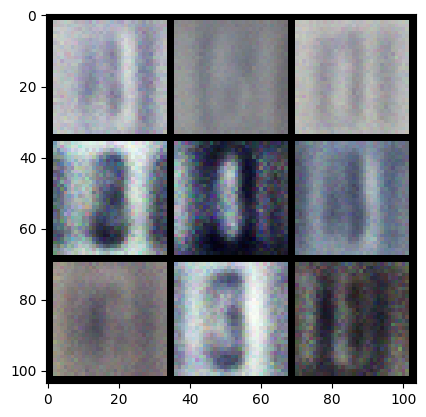

Starting epoch 6...
g_loss: 1.0732425451278687, d_loss: 1.0250296592712402


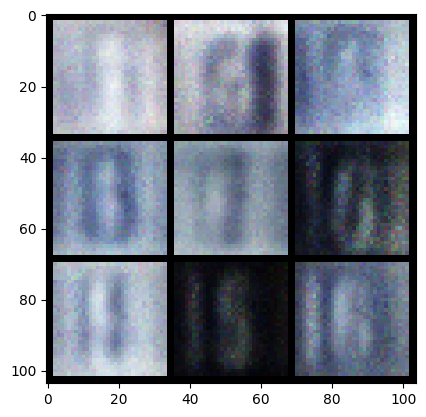

Starting epoch 7...
g_loss: 1.0487253665924072, d_loss: 1.421189785003662


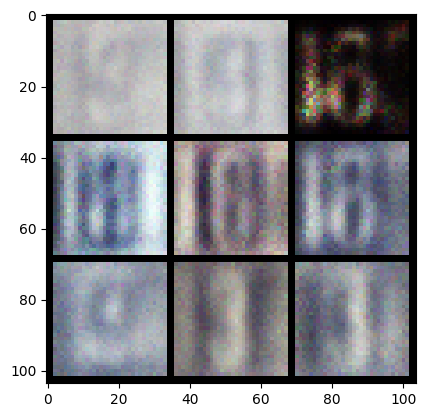

Starting epoch 8...
g_loss: 0.9500532150268555, d_loss: 0.9928374290466309


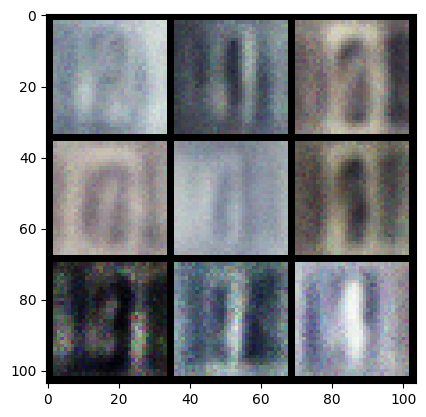

Starting epoch 9...
g_loss: 0.795417070388794, d_loss: 1.512779951095581


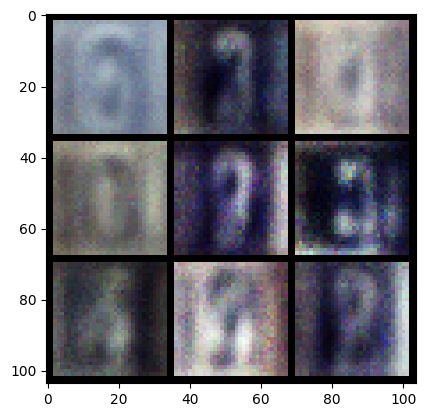

Starting epoch 10...
g_loss: 0.8278164863586426, d_loss: 1.4219839572906494


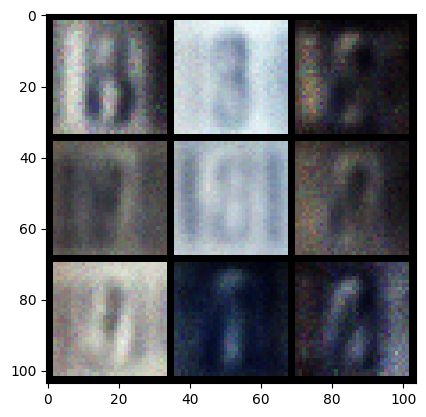

Starting epoch 11...
g_loss: 0.7377977967262268, d_loss: 1.2183631658554077


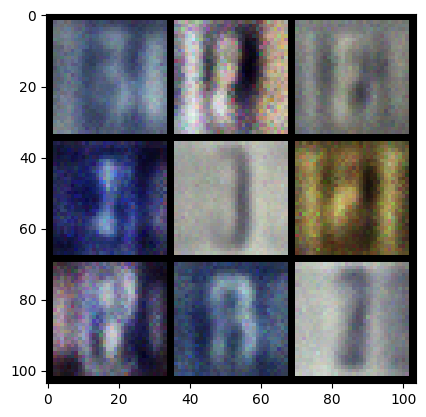

Starting epoch 12...
g_loss: 0.8984076976776123, d_loss: 1.072048544883728


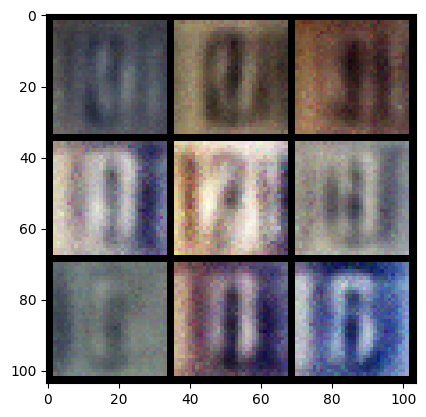

In [209]:
train_gan(epochs=epochs,generator=generator,discriminator=discriminator,train_loader=train_loader)

## - Show Generating Images

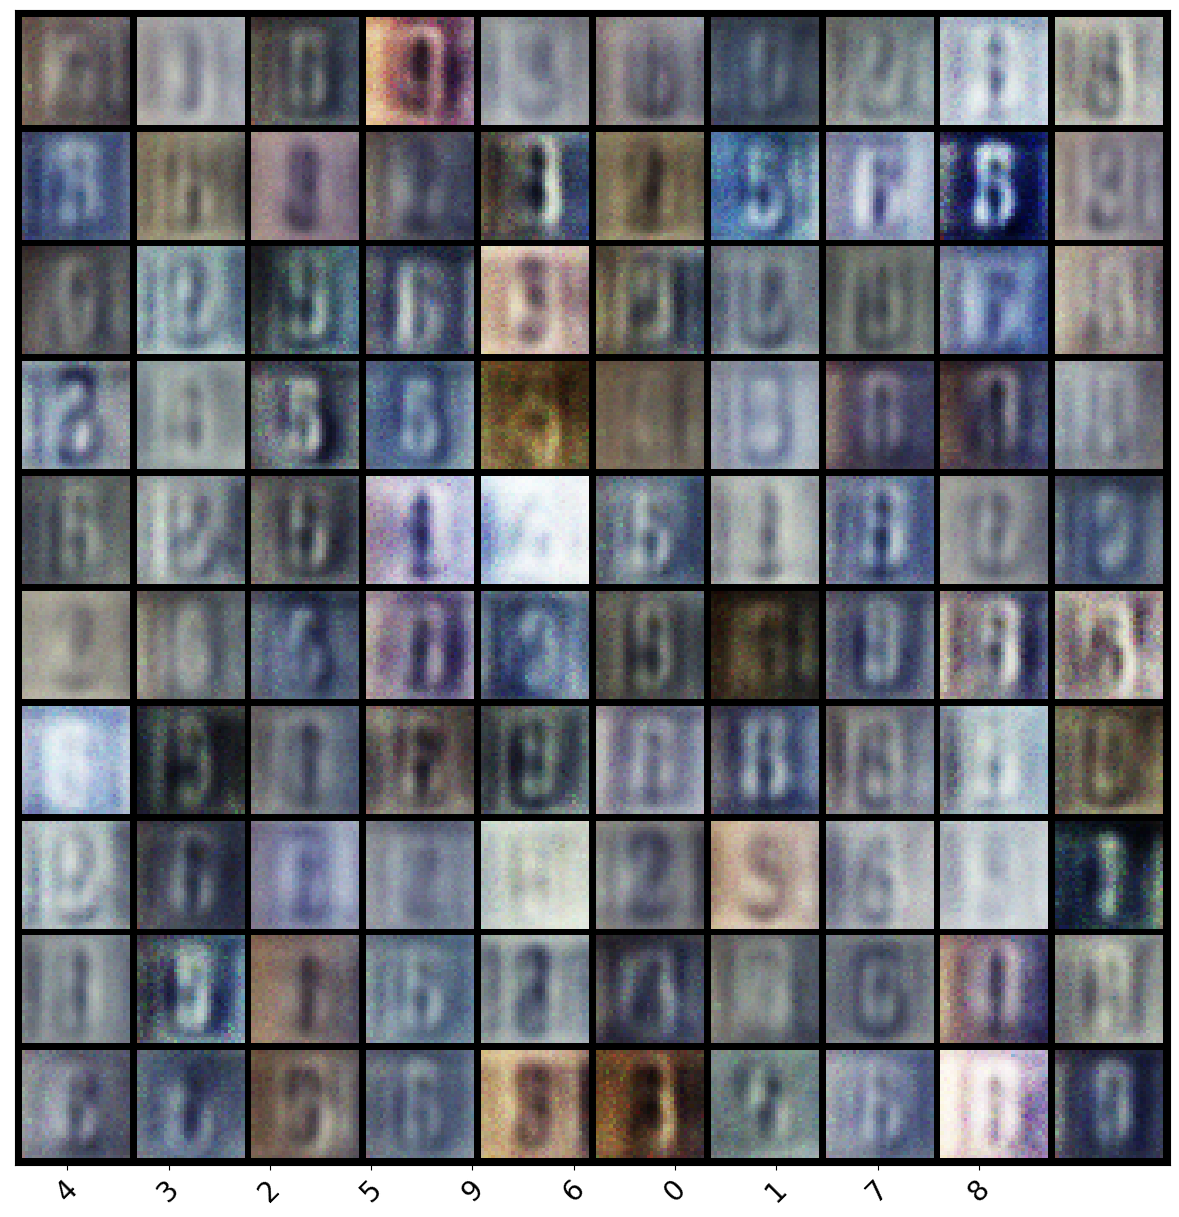

In [210]:
# Building z 
z = Variable(torch.randn(z_size, z_size)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Generating images
sample_images = generator(z, labels).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)

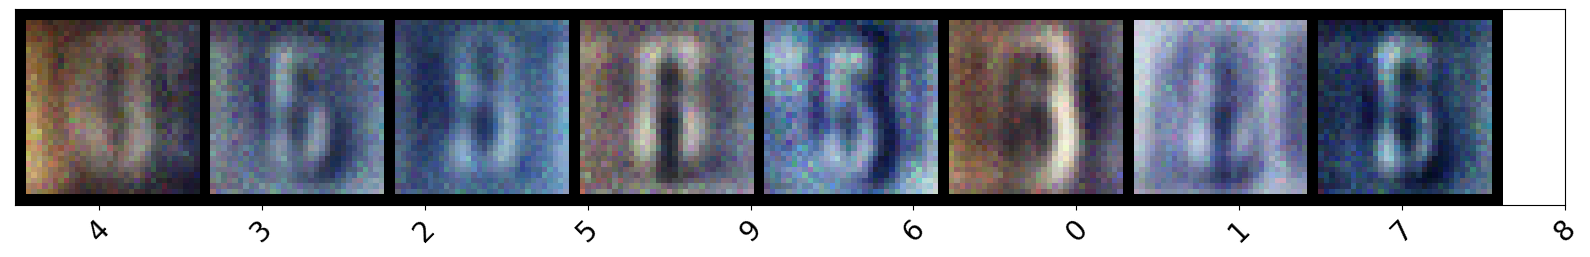

In [228]:
z2 = Variable(torch.randn(100, 8)).to(device)

# Labels 0 ~ 9
tt=[5 for i in range(8)]
labels2 = Variable(torch.LongTensor([i for i in  tt]) ).to(device)

sample_images = generator(z2, labels2).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)